In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

In [3]:
with open("filename.json", "r") as f:
    data = json.load(f)

filename = data["filename"]
filename

'wordl_population'

In [4]:
url = "https://www.worldometers.info/world-population/world-population-by-year/"

In [5]:
html = requests.get(url)

soup = BeautifulSoup(html.text, "html.parser")

In [6]:
soup

<!DOCTYPE html>
<html dir="ltr" lang="en"> <head><meta charset="utf-8"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="width=device-width, initial-scale=1" name="viewport"/><title>World Population by Year - Worldometer</title><!-- <I18nTags /> --><script async="" src="https://www.googletagmanager.com/gtag/js?id=G-ZDP3BFSX60"></script> <script>
  window.dataLayer = window.dataLayer || [];
  function gtag() {
    // eslint-disable-next-line prefer-rest-params
    dataLayer.push(arguments);
  }
  gtag("js", new Date());
  gtag("config", "G-ZDP3BFSX60", {
    page_lang: document.documentElement.lang,
  });
</script><script crossorigin="anonymous" src="https://pagead2.googlesyndication.com/pagead/js/adsbygoogle.js?client=ca-pub-3701697624350410"></script> <script async="" src="https://securepubads.g.doubleclick.net/tag/js/gpt.js"></script> <link crossorigin="" href="https://a.pub.network/" rel="preconnect"/><link crossorigin="" href="https://b.pub.network/" rel="precon

In [7]:
table = soup.find('table', class_='datatable')
print(table is None)

False


In [8]:
rows = []

for tr in table.tbody.find_all("tr"):
    tds = tr.find_all("td")
    if len(tds) < 5:
        continue

    year = int(tds[0].text.strip())

    population = int(tds[1]["data-order"])
    pct_change = (
        float(tds[2].text.replace("%", "")) 
        if tds[2].text.strip() else None
    )
    net_change = (
        int(tds[3]["data-order"]) 
        if tds[3].text.strip() else None
    )
    density = int(tds[4].text.strip())

    rows.append({
        "year": year,
        "population": population,
        "percent_change": pct_change,
        "net_change": net_change,
        "density_per_km2": density
    })

In [9]:
df = pd.DataFrame(rows)

df = df.sort_values("year").reset_index(drop=True)

print(df.head())

   year  population  percent_change  net_change  density_per_km2
0   200   190000000             NaN         NaN                1
1   600   200000000             NaN         NaN                1
2   700   210000000             NaN         NaN                1
3   800   220000000             NaN         NaN                1
4   900   240000000             NaN         NaN                2


Clean up

In [10]:
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["population"] = pd.to_numeric(df["population"], errors="coerce")
df["percent_change"] = pd.to_numeric(df["percent_change"], errors="coerce")
df["net_change"] = pd.to_numeric(df["net_change"], errors="coerce")
df["density_per_km2"] = pd.to_numeric(df["density_per_km2"], errors="coerce")

In [11]:
df.to_csv(f'{filename}.csv', index=False)

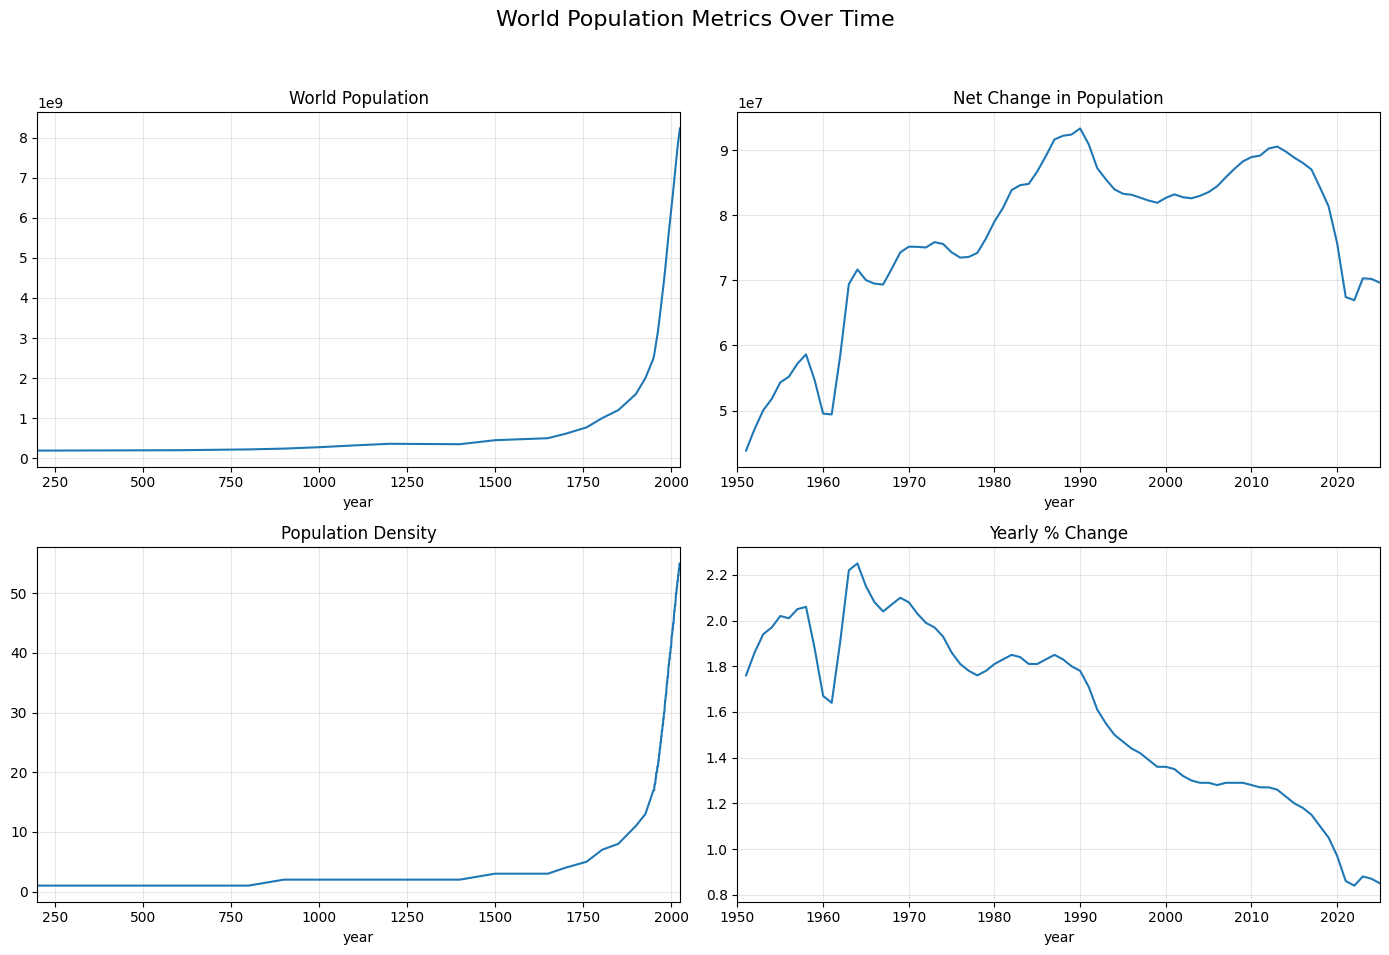

In [12]:
import matplotlib.pyplot as plt

# Sort just to be safe
df = df.sort_values("year")

# X-axis limits from the data
xmin, xmax = df["year"].min(), df["year"].max()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Population
axes[0, 0].plot(df["year"], df["population"])
axes[0, 0].set_title("World Population")
axes[0, 0].set_xlim(xmin, xmax)
axes[0, 0].grid(True, alpha=0.3)

# Yearly % Change
axes[1, 1].plot(df["year"], df["percent_change"])
axes[1, 1].set_title("Yearly % Change")
axes[1, 1].set_xlim(1950, xmax)
axes[1, 1].grid(True, alpha=0.3)

# Net Change
axes[0, 1].plot(df["year"], df["net_change"])
axes[0, 1].set_title("Net Change in Population")
axes[0, 1].set_xlim(1950, xmax)
axes[0, 1].grid(True, alpha=0.3)

# Density
axes[1, 0].plot(df["year"], df["density_per_km2"])
axes[1, 0].set_title("Population Density")
axes[1, 0].set_xlim(xmin, xmax)
axes[1, 0].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_xlabel("year")

fig.suptitle("World Population Metrics Over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
